In [3]:
from torchvision import datasets
from torchvision.transforms import ToTensor

In [4]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True
)

test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor(),
    download = True
)

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [8]:
train_data.targets # dataset.target shows the lable of the classified data

tensor([5, 0, 4,  ..., 5, 6, 8])

# What is a DataLoader ?

In PyTorch, a DataLoader is a utility class that simplifies the process of loading and iterating over datasets while training deep learning models. Here are some key features of DataLoader:

**Batching:** It can divide the dataset into smaller batches, which helps in efficient training.

**Shuffling:** It can shuffle the data to ensure that the model does not learn any unintended patterns.

**Parallel Processing:** It can load data in parallel using multiple workers, which speeds up the data loading process.

**Memory Pinning:** It can pin memory to improve the efficiency of data transfer to the GPU.

In [9]:
from torch.utils.data import DataLoader

loaders = {
    'train': DataLoader(train_data,batch_size=100,shuffle=True,num_workers=1),
    'test': DataLoader(test_data,batch_size=100,shuffle=True,num_workers=1)
}

In [10]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x2b3d74cb560>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x2b3d537dfd0>}

# What is nn.Model ?

The nn.Module parameter is actually quite important in PyTorch. When you define a neural network class, it should inherit from nn.Module. This inheritance provides your class with a lot of useful methods and attributes that are essential for building and training neural networks.

**Initialization and Structure:** By inheriting from nn.Module, your class gains the ability to register layers (like conv1, conv2, etc.) and parameters. This is crucial for PyTorch to keep track of the model’s parameters and their gradients.

**Forward Propagation:** The forward method is a special method in nn.Module that defines the forward pass of the network. When you call your model on an input, it automatically calls the forward method.

**Model Management:** Inheriting from nn.Module allows you to use various utility functions provided by PyTorch, such as model.eval(), model.train(), model.to(device), and more. These functions are essential for managing the model’s state and moving it between devices (CPU/GPU).

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):

    def __init__(self):
        super(CNN,self).__init__()

        self.conv1 = nn.Conv2d(1,10,kernel_size=5) # 1 input channel， 10 output channel, 5x5 kernel, 10 kernels
        self.conv2 = nn.Conv2d(10,20,kernel_size=5) # 20 kernels
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320,50)
        self.fc2 = nn.Linear(50,10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x),2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)),2))
        x = x.view(-1,320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return F.softmax(x)
    

**1.First Convolutional Layer (conv1):**
- Input: 1 channel, 28x28 (assuming MNIST dataset)
- Output: 10 channels, 24x24 (since kernel size is 5, the output size is reduced by 4)

**2.First Max Pooling Layer:**
- Output: 10 channels, 12x12 (pooling with kernel size 2 reduces each dimension by half)

**3.Second Convolutional Layer (conv2):**
- Input: 10 channels, 12x12
- Output: 20 channels, 8x8 (again, kernel size 5 reduces each dimension by 4)

**4.Second Max Pooling Layer:**
- Output: 20 channels, 4x4 (pooling with kernel size 2 reduces each dimension by half)

After these layers, the feature map has dimensions 20 channels x 4 height x 4 width. When you flatten this for the fully connected layer, you get (20 \times 4 \times 4 = 320) units.

So, the input to the first fully connected layer (fc1) is 320 units.

In [12]:
import torch 

print(torch.cuda.is_available())
print(torch.__version__)
print(torch.version.cuda)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device


True
2.4.1+cu124
12.4


device(type='cuda')

In [13]:
model = CNN().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for batch_index, (data,target) in enumerate(loaders['train']):
        data,target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output,target)
        loss.backward()
        optimizer.step()
        if batch_index % 20 == 0:
            print(f'Train Epoch: {epoch} [{batch_index*len(data)}/{len(loaders["train"].dataset)} ({100.*batch_index/len(loaders["train"]):.0f}%)]\t{loss.item():.6f}')

def test():
    model.eval()

    test_loss = 0
    correct = 0 

    with torch.no_grad():
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output,target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(loaders['test'].dataset)
    print(f'\nTest set: Average loss {test_loss:.4f}, Accuracy {correct}/{len(loaders["test"].dataset)}({100.*correct/len(loaders["test"].dataset):.0f}%\n)')

In [14]:
for epoch in range(1,11):
    train(epoch)
    test()

C:\Users\jerry\AppData\Local\Temp\ipykernel_3288\2577003603.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Train Epoch: 1 [0/60000 (0%)]	2.303684
Train Epoch: 1 [2000/60000 (3%)]	2.294044
Train Epoch: 1 [4000/60000 (7%)]	2.212990
Train Epoch: 1 [6000/60000 (10%)]	2.112004
Train Epoch: 1 [8000/60000 (13%)]	1.928479
Train Epoch: 1 [10000/60000 (17%)]	1.938187
Train Epoch: 1 [12000/60000 (20%)]	1.902271
Train Epoch: 1 [14000/60000 (23%)]	1.890950
Train Epoch: 1 [16000/60000 (27%)]	1.775415
Train Epoch: 1 [18000/60000 (30%)]	1.854022
Train Epoch: 1 [20000/60000 (33%)]	1.743333
Train Epoch: 1 [22000/60000 (37%)]	1.717463
Train Epoch: 1 [24000/60000 (40%)]	1.673501
Train Epoch: 1 [26000/60000 (43%)]	1.686477
Train Epoch: 1 [28000/60000 (47%)]	1.693278
Train Epoch: 1 [30000/60000 (50%)]	1.701470
Train Epoch: 1 [32000/60000 (53%)]	1.676902
Train Epoch: 1 [34000/60000 (57%)]	1.649023
Train Epoch: 1 [36000/60000 (60%)]	1.606541
Train Epoch: 1 [38000/60000 (63%)]	1.636781
Train Epoch: 1 [40000/60000 (67%)]	1.617451
Train Epoch: 1 [42000/60000 (70%)]	1.616845
Train Epoch: 1 [44000/60000 (73%)]	1.588206

C:\Users\jerry\AppData\Local\Temp\ipykernel_3288\2577003603.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Prediction: 7


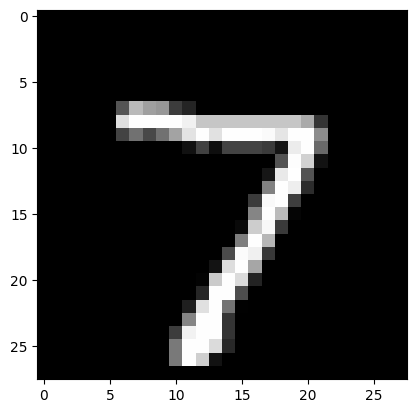

In [16]:
import matplotlib.pyplot as plt

model.eval()

data, target = test_data[0]

data = data.unsqueeze(0).to(device)

output = model(data)

prediction = output.argmax(dim=1, keepdim=True).item()

print(f'Prediction: {prediction}')

image = data.squeeze(0).squeeze(0).cpu().numpy()

plt.imshow(image, cmap='gray')
plt.show()
